In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=15a78ec0755776a1cd444b776394ae240246a513cb8702b59ca9f33fb5f62b2e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import pathlib
import glob
import lime
import lime.lime_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not os.path.exists("./data/train/no pothole"):
    os.makedirs("./data/train/no pothole")
    os.makedirs("./processed/train/no pothole")
if not os.path.exists("./data/train/pothole"):
    os.makedirs("./data/train/pothole")
    os.makedirs("./processed/train/pothole")
if not os.path.exists("./data/test/no pothole"):
    os.makedirs("./data/test/no pothole")
    os.makedirs("./processed/test/no pothole")
if not os.path.exists("./data/test/pothole"):
    os.makedirs("./data/test/pothole")
    os.makedirs("./processed/test/pothole")
if not os.path.exists("./data/val/no pothole"):
    os.makedirs("./data/val/no pothole")
    os.makedirs("./processed/val/no pothole")
if not os.path.exists("./data/val/pothole"):
    os.makedirs("./data/val/pothole")
    os.makedirs("./processed/val/pothole")

In [ ]:
main_path  = '/content/drive/MyDrive/Pothole Detection Model/all_data'
images = os.listdir(main_path )
len(images)

5676

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Pothole Detection Model/train_ids_labels.csv')
df_potholes = df[df['Label'] == 1].copy()
df_no_potholes = df[df['Label'] == 0].copy()
pothole_images = df_potholes['Image_ID']
no_pothole_images = df_no_potholes['Image_ID']
print(len(pothole_images))
print(len(no_pothole_images))

1661
2365


/content/drive/MyDrive/Pothole Detection Model/all_data
tYKqoStvHsryFhS
/content/drive/MyDrive/Pothole Detection Model/all_data/tYKqoStvHsryFhS.JPG


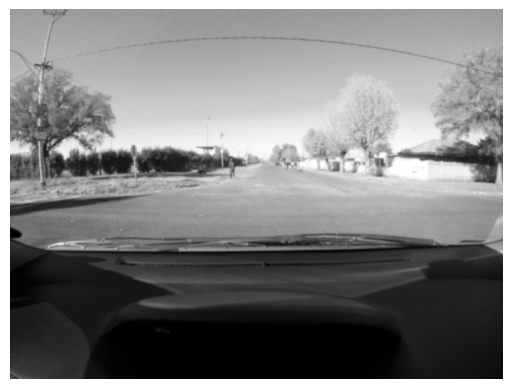

In [ ]:
# Load the image
print(main_path)
print(list(pothole_images)[0])
print(f'{main_path}/{list(pothole_images)[0]}.JPG')
image = cv2.imread(f'{main_path}/{list(pothole_images)[0]}.JPG')

# Apply Gaussian blur to grayscale image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Display the blurred grayscale image
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# perform test train test split for sick images
# Using 80% of the dataset for training and 20% for Testing
# The validation datatset is 20% of the training set
def populate_no_pothole_images_folders(no_pothole_images, path):
    for i,img in enumerate(no_pothole_images):
        if i <  1513:
            shutil.copy(os.path.join(path, f'{img}.JPG'),
                      os.path.join(f"data/train/no pothole", f'{img}.JPG'))
        elif i > 232 and i < (1513+473):
            shutil.copy(os.path.join(path, f'{img}.JPG'),
                      os.path.join(f"data/test/no pothole", f'{img}.JPG'))
        else:
              if i > 2365:
                return
              shutil.copy(os.path.join(path, f'{img}.JPG'),
                          os.path.join(f"data/val/no pothole", f'{img}.JPG'))
    return
populate_no_pothole_images_folders(no_pothole_images,main_path )

In [ ]:
# perform test train test split for sick images
# Using 80% of the dataset for training and 20% for Testing
# The validation datatset is 20% of the training set
def populate_pothole_images_folders(pothole_images, path):
    for i,img in enumerate(pothole_images):
        if i <  1062:
            shutil.copy(os.path.join(path, f'{img}.JPG'),
                      os.path.join(f"data/train/pothole", f'{img}.JPG'))
        elif i > 1062 and i < (1062+338):
            shutil.copy(os.path.join(path, f'{img}.JPG'),
                      os.path.join(f"data/test/pothole", f'{img}.JPG'))
        else:
              if i > 1661:
                return
              shutil.copy(os.path.join(path, f'{img}.JPG'),
                          os.path.join(f"data/val/pothole", f'{img}.JPG'))
    return
populate_pothole_images_folders(pothole_images,main_path )

In [ ]:
# function to preprocess the images
def preprocess_images(url, thresh_type, path):
  print(url,path)
  data = pathlib.Path(url)
  processed_images = []
  known_images = list(data.glob('*.JPG'))
  counter = 0
  for i in known_images:
    counter +=1
    img = cv2.imread(str(i))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gaussian_filtered = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
    cv2.imwrite(path+'/'+str(counter)+'.JPG', gaussian_filtered)
  print(counter)

In [ ]:
path_to_save = "./processed/train/no pothole"
default_images = pathlib.Path('./data/train/no pothole')
processed_images = preprocess_images(default_images, "gaussian",path_to_save)

data/train/no pothole ./processed/train/no pothole
1513


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
EPOCHS = 100
BATCH_SIZE = 40

In [ ]:
data_generator = ImageDataGenerator(
    rescale=1.0/255.0,
)


train_data_path = "processed/train"
test_data_path = "processed/test"
validation_data_path = "processed/val"

trainDS = data_generator.flow_from_directory(train_data_path,
                                             target_size=(256, 256),
                                             class_mode="binary",
                                             batch_size=BATCH_SIZE)

validationDS = data_generator.flow_from_directory(validation_data_path,
                                                  target_size=(256, 256),
                                                  class_mode="binary",
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

testDS = data_generator.flow_from_directory(test_data_path,
                                            target_size=(256, 256),
                                            class_mode="binary",
                                            shuffle=False,
                                            batch_size=BATCH_SIZE)

Found 2575 images belonging to 2 classes.
Found 641 images belonging to 2 classes.
Found 810 images belonging to 2 classes.


In [ ]:
import keras
from keras.layers import Conv2D,  MaxPooling2D, Flatten, Dense, Input,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [ ]:
model = keras.models.Sequential([
    Conv2D(128, (3,3), activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation="relu"),
    Dropout(0.1),
    BatchNormalization(),
    Dense(1, activation="sigmoid")
])

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="binary_crossentropy",metrics=['accuracy'])

In [ ]:
# setting callbacks for our model
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
)

best_model = ModelCheckpoint('bestmodel.hdf5', monitor='val_accuracy', save_best_only=True)
history = model.fit(trainDS,
           epochs=EPOCHS,
           batch_size=BATCH_SIZE,
           validation_data=validationDS,
           callbacks=[best_model, reduce_lr_on_plateau, early_stopping_monitor]
           )

Epoch 1/100
65/65 [==============================] - 24s 333ms/step - loss: 0.5946 - accuracy: 0.7002 - val_loss: 0.5908 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 2/100
65/65 [==============================] - 18s 272ms/step - loss: 0.4561 - accuracy: 0.7880 - val_loss: 0.4020 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 3/100
65/65 [==============================] - 19s 286ms/step - loss: 0.3456 - accuracy: 0.8478 - val_loss: 0.3492 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 4/100
65/65 [==============================] - 18s 268ms/step - loss: 0.2841 - accuracy: 0.8777 - val_loss: 0.4071 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 5/100
65/65 [==============================] - 18s 269ms/step - loss: 0.2735 - accuracy: 0.8808 - val_loss: 0.5429 - val_accuracy: 0.7036 - lr: 0.0010
Epoch 6/100
65/65 [==============================] - 20s 306ms/step - loss: 0.2511 - accuracy: 0.8928 - val_loss: 0.2555 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 7/100
65/65 [==============================] - 18s 2

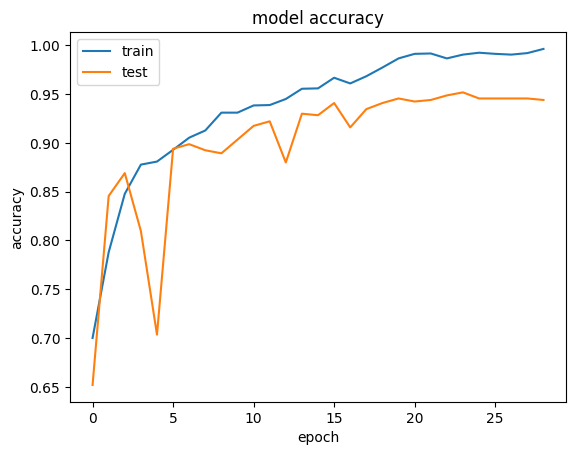

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

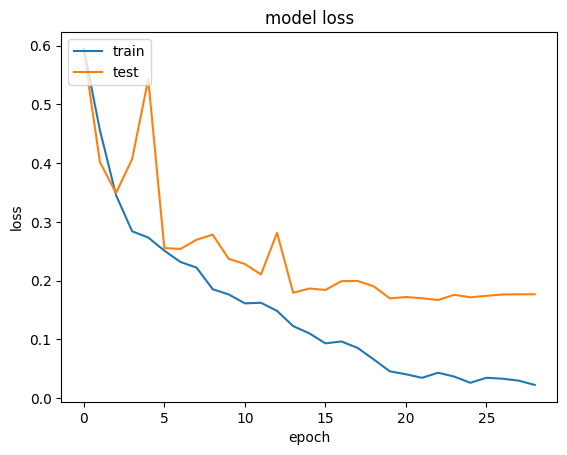

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

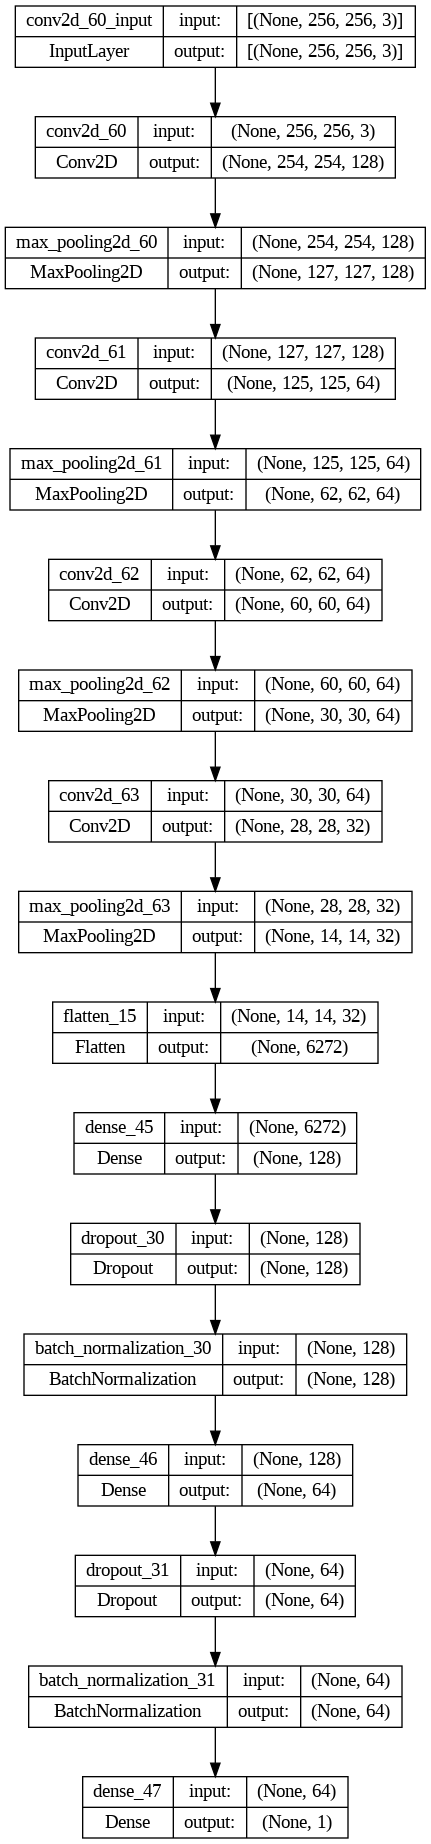

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_evaluation = model.evaluate(testDS)
print(f"Test Accuracy: {model_evaluation[1] * 100:.2f}%")

model_evaluation = model.evaluate(trainDS)
print(f"Train Accuracy: {model_evaluation[1] * 100:.2f}%")

21/21 [==============================] - 5s 223ms/step - loss: 0.1473 - accuracy: 0.9519
Test Accuracy: 95.19%
65/65 [==============================] - 13s 198ms/step - loss: 0.0099 - accuracy: 0.9992
Train Accuracy: 99.92%


In [ ]:
prediction = model.predict(testDS)

21/21 [==============================] - 4s 172ms/step


In [ ]:
y_pred = (prediction > 0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report,roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       496
           1       0.91      0.97      0.94       314

    accuracy                           0.95       810
   macro avg       0.95      0.96      0.95       810
weighted avg       0.95      0.95      0.95       810



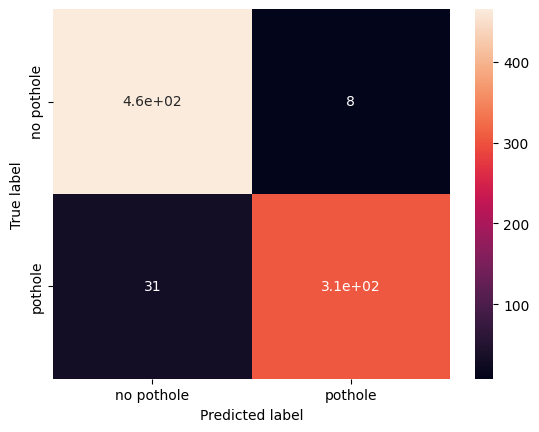

In [ ]:
# Generate status classification report
print(classification_report(y_pred, testDS.classes))

# confusion matrix
cm_status = confusion_matrix(testDS.classes, y_pred)

# Retrieve the class labels
class_labels = list(trainDS.class_indices.keys())

# Plot status confusion matrix as heatmap
sns.heatmap(cm_status, annot=True, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
def generate_auc_roc_params(cm,y_true,y_pred):
        # Compute the confusion matrix
        tn, fp, fn, tp = cm.ravel()
        uac = tp / (tp + fn)
        auc = roc_auc_score(testDS.classes, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        return  tn, fp, fn, tp,uac, auc, fpr, tpr, thresholds


def draw_roc(fpr,tpr,auc):
        # Plot the ROC curve
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (AUC = {:.2f})'.format(auc))
        plt.show()


def draw_auc(tn,fp,auc):
        # Plot the UAC bar chart
        plt.bar(['0', '1'], [tn / (tn + fp), tp / (tp + fn)])
        plt.xlabel('True Label')
        plt.ylabel('Accuracy')
        plt.title('UAC Chart (UAC = {:.2f})'.format(uac))
        plt.show()

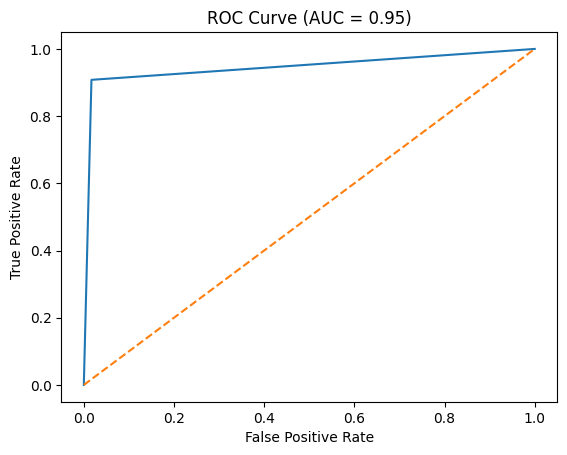

In [ ]:
tn, fp, fn, tp,uac, auc, fpr, tpr, thresholds =generate_auc_roc_params(cm_status,testDS.classes, y_pred)
draw_roc(fpr,tpr,auc)

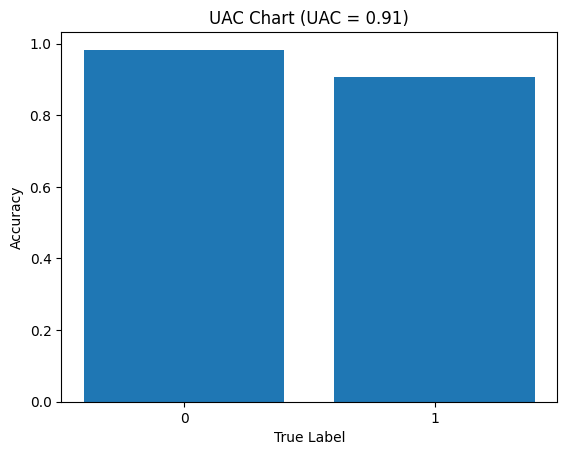

In [ ]:
draw_auc(tn,fp,auc)

In [ ]:
# Initialize the LIME explainer
explainer = lime.lime_image.LimeImageExplainer()

In [ ]:
# Define the function to predict using your TensorFlow CNN model
def predict_fn(images):
    predictions = model.predict(images)
    return predictions

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


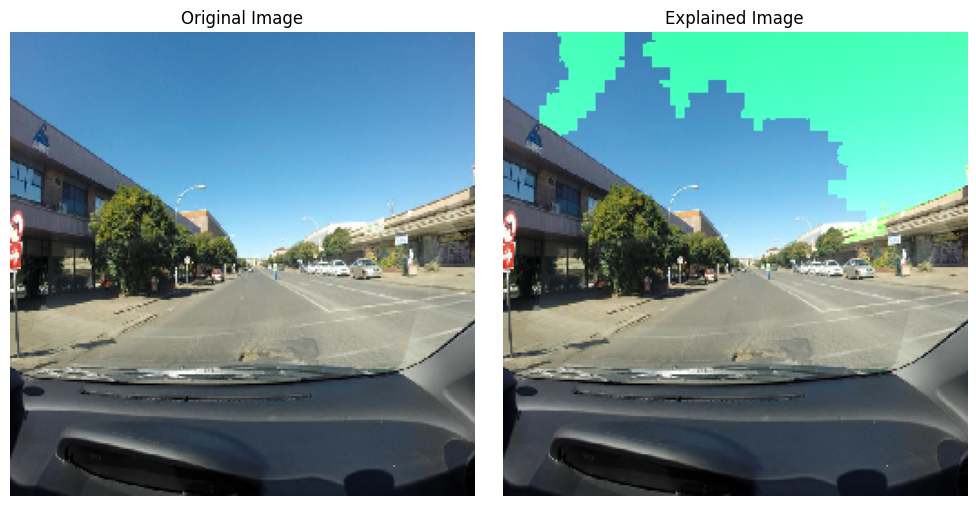

In [ ]:
# Load the original image
image_path = "/content/data/test/pothole/aazjfeBcQJWnIZi.JPG"
original_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
original_image = tf.keras.preprocessing.image.img_to_array(original_image)
original_image = original_image.astype(np.uint8)

# Create the LimeImageExplainer with adjusted parameters
explainer = lime.lime_image.LimeImageExplainer(kernel_width=0.1)

# Define the function to predict using your TensorFlow CNN model
def predict_fn(images):
    predictions = model.predict(images)
    return predictions

# Generate LIME explanations with increased num_samples
num_samples = 2000
explanation = explainer.explain_instance(original_image, predict_fn, top_labels=1, num_samples=num_samples)

# Get the important features and their weights
image_with_mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, hide_rest=False)

# Create a subplot to display the original and explained images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(original_image / 255.0)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the explained image
axes[1].imshow(image_with_mask[0])
axes[1].set_title('Explained Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
model.save('pothole_model.h5')